Будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).

Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. <br>Затем решим задачу определения вида физической активности именно как задачу классификации.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [3]:
X_train[:1,12]

array([0.85294738])

In [4]:
print(X_train.shape, X_test.shape, sep='    ')

(7352, 561)    (2947, 561)


In [5]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок:

In [6]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [7]:
X.shape

(10299, 561)

Определим число уникальных значений меток целевого класса:

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size

Эти метки соответствуют:
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидячему положению
- 5 - стоячему положению
- 6 - лежачему положению

Отмасштабируем выборку с помощью StandardScaler с параметрами по умолчанию:

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [12]:
X_scaled.shape

(10299, 561)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных (random_state=RANDOM_STATE):

In [13]:
%%time
pca = PCA(random_state=RANDOM_STATE).fit(X_scaled)

CPU times: user 1.6 s, sys: 127 ms, total: 1.72 s
Wall time: 1.32 s


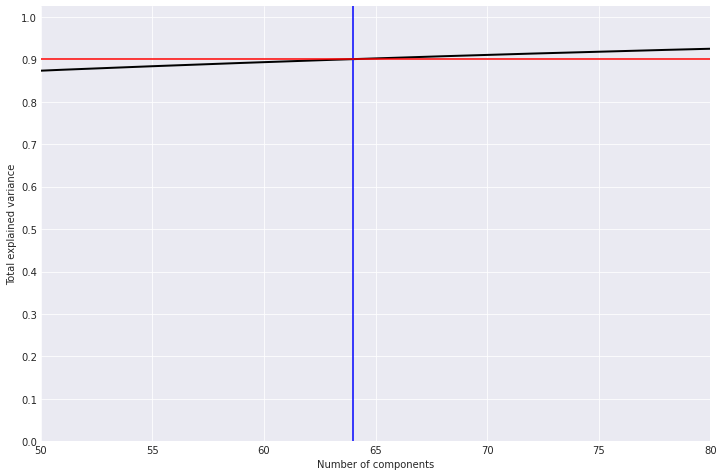

In [14]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(50, 80)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(64, c='b')
plt.axhline(0.9, c='r')
plt.show();

Так сложно понять, переберем между 60 и 70:

In [15]:
for i in range(60,71):
    pca_tmp = PCA(n_components=i, random_state=RANDOM_STATE).fit(X_scaled)
    print("i=", i, ";  ", np.cumsum(pca_tmp.explained_variance_ratio_).max(), sep="")

i=60;  0.8907669485078438
i=61;  0.8926354927892646
i=62;  0.8945785683713907
i=63;  0.8963572582918559
i=64;  0.8980586328034721
i=65;  0.8997840389399008
i=66;  0.9015056286454436
i=67;  0.9032848131223211
i=68;  0.904967926437488
i=69;  0.9066161031459946
i=70;  0.9081357527781954


In [16]:
%%time
pca = PCA(n_components=65, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

CPU times: user 1.05 s, sys: 103 ms, total: 1.15 s
Wall time: 482 ms


In [17]:
# Посчитаем, сколько процентов дисперсии приходится на первую и вторую главные компоненты
print(pca.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_[1])

0.5073822103501328
0.06239185775196494


Визуализируем данные в проекции на первые две главные компоненты:

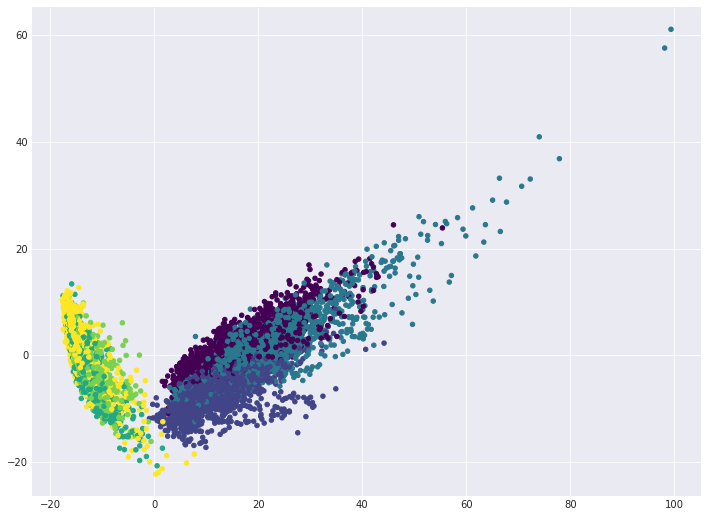

In [18]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis');

Видим сколько-то кластеров, почти идеально отделенных друг от друга.
<br>2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание).

---

Сделаем кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае известно, что нужно искать именно 6 кластеров, но в общем случае это не так:

In [19]:
kmeans = KMeans(n_clusters = n_classes, n_init = 100, random_state = RANDOM_STATE).fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

kmeans.labels_

array([5, 5, 5, ..., 0, 0, 0], dtype=int32)

In [20]:
kmeans.n_iter_

26

In [21]:
kmeans.inertia_

2000510.8783233215

Визуализируем данные в проекции на первые две главные компоненты. Раскрасим точки в соответствии с полученными метками кластеров:

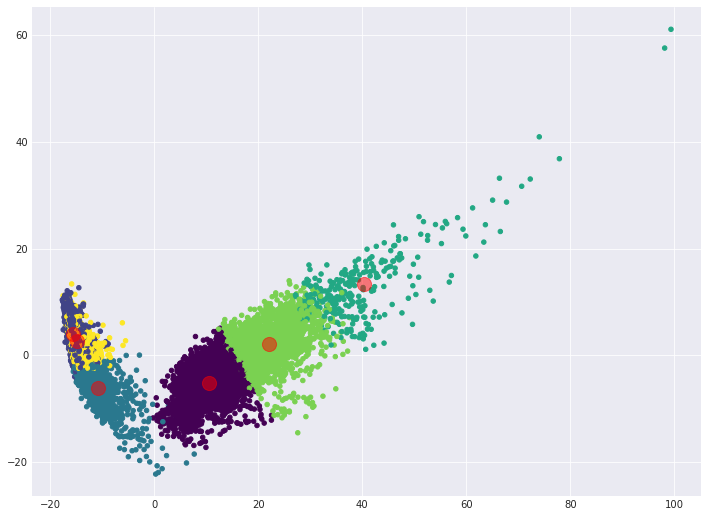

In [22]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, s=20,  cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

Посмотрим на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм KMeans путает:

In [23]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,2,5,296,0,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,91,450,0,0,1235,1777
стояние,0,0,562,0,0,1344,1906
лежание,5,1557,329,0,0,53,1944
все,2470,1648,1343,279,1927,2632,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов, распределение кластеров такое:
<br>кластер 1 – 900
<br>кластер 3 – 500
<br>кластер 6 – 6,
<br>то такая доля будет 900 / 1406 ≈ 0.64.

По такой метрике "подъем вверх" и "лежание" виды активности отделяются от остальных лучше всего.

In [24]:
tab = pd.crosstab(y_kmeans, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,2470,0,0,0,0,0,2470
подъем вверх по лестнице,0,1648,0,0,0,0,1648
спуск по лестнице,0,0,1343,0,0,0,1343
сидение,0,0,0,279,0,0,279
стояние,0,0,0,0,1927,0,1927
лежание,0,0,0,0,0,2632,2632
все,2470,1648,1343,279,1927,2632,10299


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используем метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только n_clusters:

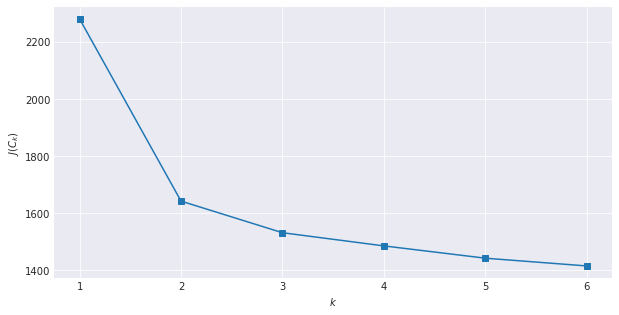

In [25]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

По методу локтя оптимальным числом кластеров будет 2.

In [26]:
kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

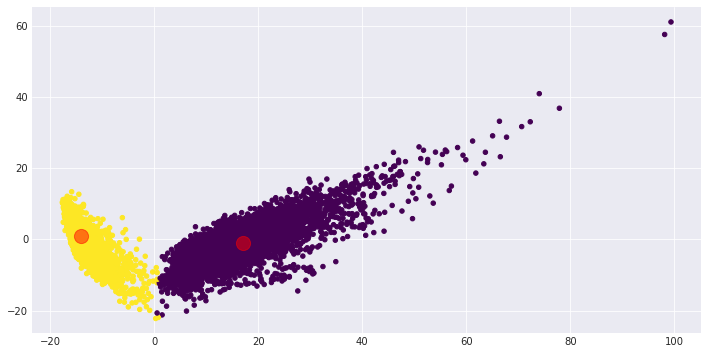

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, s=20,  cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

---

Попробуем еще один метод кластеризации: агломеративную кластеризацию:

In [28]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X_pca)

In [29]:
ag.labels_

array([2, 2, 2, ..., 0, 0, 0])

Посчитаем Adjusted Rand Index для получившегося разбиения на кластеры и для KMeans.

*The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings*.

In [30]:
print(metrics.adjusted_rand_score(y, ag.labels_))
print(metrics.adjusted_rand_score(y, kmeans.labels_))

0.5163347180119854
0.3296106738894193


---

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Решим теперь задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используем метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не <br>Настроим для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`:

In [31]:
scaler = StandardScaler().fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
print(X_train_scaled.shape, X_test_scaled.shape)

(7352, 561) (2947, 561)


In [33]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [34]:
CV_svc = GridSearchCV(estimator=svc, 
                      param_grid=svc_params, 
                      cv=3)
CV_svc.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [35]:
CV_svc.best_params_

{'C': 1}

In [36]:
CV_svc.best_score_

0.9464116548292103

In [37]:
y_predicted = CV_svc.predict(X_test_scaled)

In [38]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,429,40,5,13,9,0,496
подъем вверх по лестнице,0,466,1,4,0,0,471
спуск по лестнице,1,15,377,10,17,0,420
сидение,2,6,0,347,135,1,491
стояние,2,2,0,9,519,0,532
лежание,1,1,1,30,15,489,537
все,435,530,384,413,695,490,2947


In [39]:
print(metrics.precision_score(y_test, y_predicted, average='micro'))
print(metrics.precision_score(y_test, y_predicted, average='macro'))

0.8914149983033594
0.9053564151843227


In [40]:
print(metrics.recall_score(y_test, y_predicted, average='micro'))
print(metrics.recall_score(y_test, y_predicted, average='macro'))

0.8914149983033594
0.8908036839526576


В общем, точность и полнота в мультиклассовой классификации нормальные.

Проделаем то же самое, что и на прошлом шаге, только добавив PCA:

In [41]:
%%time
pca = PCA(n_components=65, random_state=RANDOM_STATE).fit(X_train_scaled)
X_pca_train_scaled = pca.transform(X_train_scaled)
X_pca_test_scaled = pca.transform(X_test_scaled)

CPU times: user 840 ms, sys: 97.5 ms, total: 937 ms
Wall time: 356 ms


In [42]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [43]:
CV_svc = GridSearchCV(estimator=svc, 
                      param_grid=svc_params, 
                      cv=3)
CV_svc.fit(X_pca_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [44]:
CV_svc.best_params_

{'C': 1}

In [45]:
CV_svc.best_score_

0.9020701254798125

Было: 0.9464116548292103

In [46]:
y_pca_predicted = CV_svc.predict(X_pca_test_scaled)

In [47]:
tab = pd.crosstab(y_test, y_pca_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,475,15,5,0,0,1,496
подъем вверх по лестнице,43,417,11,0,0,0,471
спуск по лестнице,15,50,355,0,0,0,420
сидение,0,3,0,416,72,0,491
стояние,1,0,0,42,489,0,532
лежание,0,0,0,1,0,536,537
все,534,485,371,459,561,537,2947


In [48]:
print(metrics.precision_score(y_test, y_pca_predicted, average='micro'))
print(metrics.precision_score(y_test, y_pca_predicted, average='macro'))

0.9121140142517815
0.9137156463029245


Было:
<br>0.8914149983033594
<br>0.9053564151843227

In [49]:
print(metrics.recall_score(y_test, y_pca_predicted, average='micro'))
print(metrics.recall_score(y_test, y_pca_predicted, average='macro'))

0.9121140142517815
0.9088018246891477


Было:
<br>0.8914149983033594
<br>0.8908036839526576